Problem 1

Parameters of the largest circle:
Center: (251, 175)
Radius: 13
Range of σ values used: 0.01 to 6.609999999999999


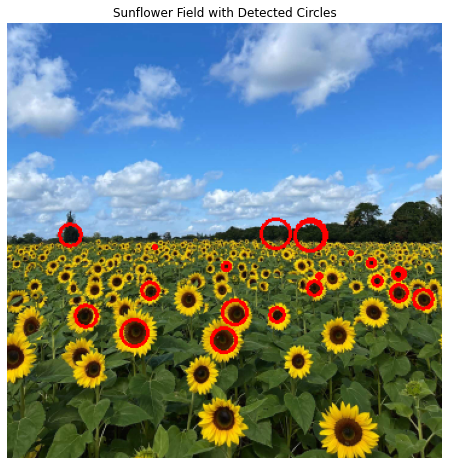

In [69]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

# Load the image
im = cv.imread('the_berry_farms_sunflower_field.jpeg', cv.IMREAD_REDUCED_COLOR_4)

im_rgb = cv.cvtColor(im, cv.COLOR_BGR2RGB)
gray = cv.cvtColor(im, cv.COLOR_BGR2GRAY)


# Variables
min_radius = 1  # Minimum circle radius
max_radius = 600 # Maximum circle radius
sigma_values = np.arange(0.01, 6.7, 0.3)  # Range of sigma values to use

# Initialize an empty list to store detected circles
circles = []

for sigma in sigma_values:
    # Apply Gaussian blur with the current sigma
    blurred = cv.GaussianBlur(gray, (0, 0), sigmaX=sigma)
    
    # Apply Laplacian of Gaussian (LoG) to find zero-crossings
    log = cv.Laplacian(blurred, cv.CV_64F)
    
    # Find the local extrema in the LoG image
    min_val, max_val, min_loc, max_loc = cv.minMaxLoc(log)
    
    # Threshold the LoG image to detect extrema
    threshold = 0.6
    if max_val > threshold:
        radius = int(sigma * 2)
        
        if min_radius <= radius <= max_radius:
            circles.append((max_loc[0], max_loc[1], radius))


circles.sort(key=lambda x: x[2], reverse=True)

largest_circle = circles[0]

center_x, center_y, radius = largest_circle

print("Parameters of the largest circle:")
print(f"Center: ({center_x}, {center_y})")
print(f"Radius: {radius}")
print(f"Range of σ values used: {sigma_values[0]} to {sigma_values[-1]}")


im_with_circles = im_rgb.copy()
# Draw circles on the copy of the image
for circle in circles:
    center_x, center_y, radius = circle
    cv.circle(im_with_circles, (center_x, center_y), radius, (255, 0, 0), 2)

plt.figure(figsize=(8, 8))
plt.imshow(im_with_circles)
plt.title("Sunflower Field with Detected Circles")
plt.axis("off")
plt.show()


Problem 03

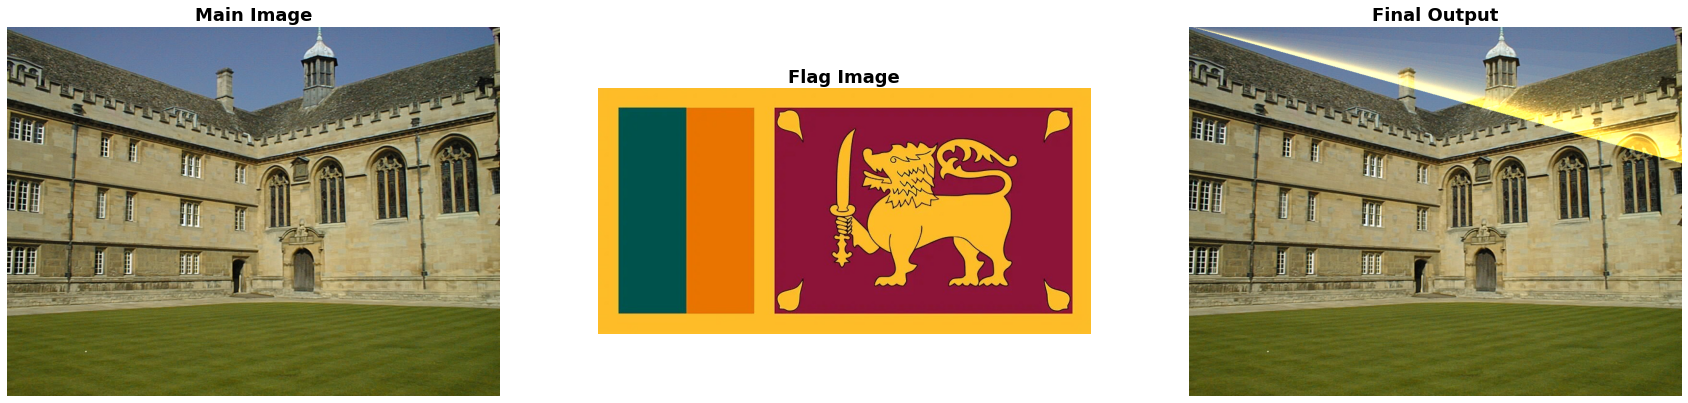

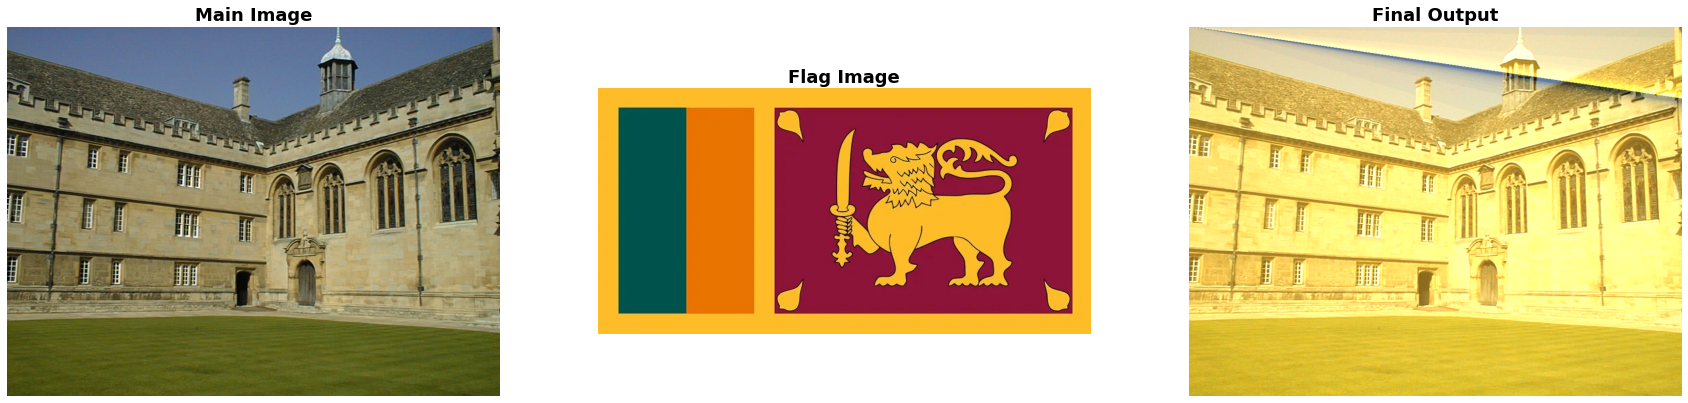

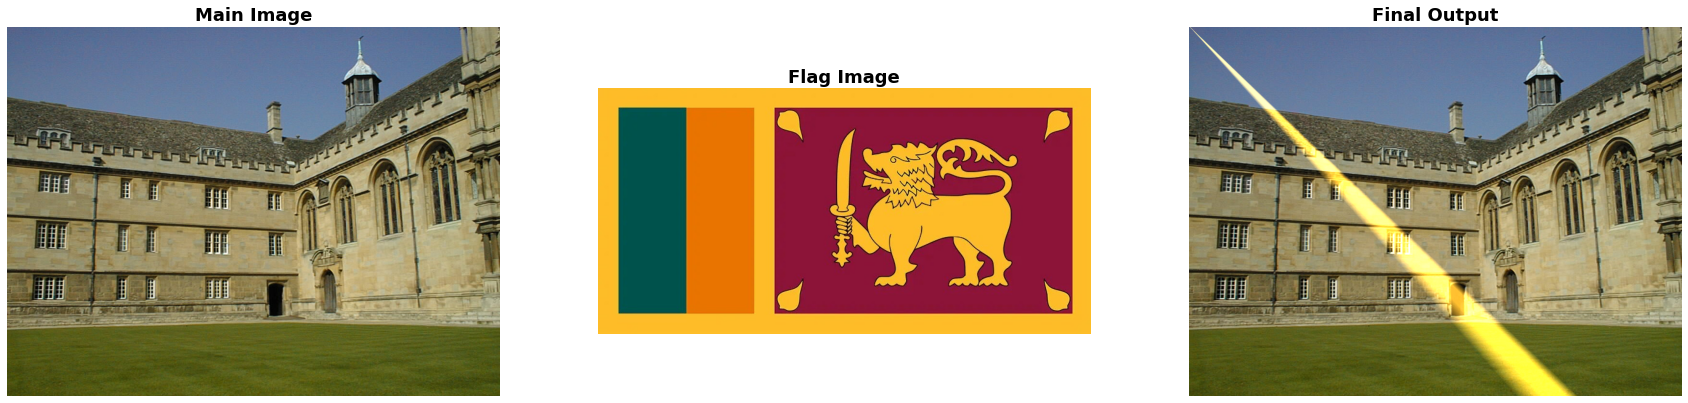

In [1]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt


images = [cv.imread(r"001.jpg"),cv.imread(r"002.jpg"), cv.imread(r"003.jpg")]
for k in range(3):

    im = images[k]
    flag = cv.imread(r"1.jpg")

    cordinates = []
    def click(event, x, y, flags, params):
        if event == cv.EVENT_LBUTTONDOWN:
            cordinates.append([x,y])
        

    cv.imshow('image', im)
    cv.setMouseCallback('image', click)
    cv.waitKey(0)
    cv.destroyAllWindows()

    h, w = np.shape(im)[0], np.shape(im)[1]
    zero_matrix = np.array([[0],[0],[0]])

    for i in range (4):
        for j in range (2):
            globals()[["x","y"][j]+"_dash_"+str(i+1)] = cordinates[i][j]
            
    flag_h , flag_w = np.shape(flag)[0] , np.shape(flag)[1]

    x1T = np.array([[0,0,1]])
    x2T = np.array([[flag_w-1, 0,1]])
    x3T = np.array([[flag_w-1, flag_h-1, 1]])
    x4T = np.array([[0,flag_h-1,1]])

    for i in range(4):
        a = np.concatenate((zero_matrix.T,globals()["x"+str(i+1)+"T"], -globals()["y_dash_"+str(i+1)]*globals()["x"+str(i+1)+"T"]), axis=1)
        b = np.concatenate((globals()["x"+str(i+1)+"T"],zero_matrix.T, -globals()["x_dash_"+str(i+1)]*globals()["x"+str(i+1)+"T"]), axis=1)
        if i==0:
            A=np.concatenate((a,b), axis=0 )
        else:
            A=np.concatenate((A,a,b), axis=0 )
            
    W,V = np.linalg.eig((A.T)@A)
    temp = V[:, np.argmin(W)]
    H = temp.reshape((3,3))

    flag_trans = cv.warpPerspective(flag, H,(w,h))
    final_output = cv.add(flag_trans,im)

    fig, ax = plt.subplots(1,3,figsize=(30,30))
    ax[0].imshow(cv.cvtColor(im, cv.COLOR_BGR2RGB))
    ax[0].set_title("Main Image",fontweight ="bold",fontsize = 18)
    ax[0].axis("off")

    ax[1].imshow(cv.cvtColor(flag, cv.COLOR_BGR2RGB))
    ax[1].set_title("Flag Image",fontweight ="bold",fontsize = 18)
    ax[1].axis("off")

    ax[2].imshow(cv.cvtColor(final_output, cv.COLOR_BGR2RGB))
    ax[2].set_title("Final Output",fontweight ="bold",fontsize = 18)
    ax[2].axis("off")
    plt.show()